<a href="https://colab.research.google.com/github/carlosvalenciano/Project4/blob/main/Stock_Market_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install yahoo_fin

In [17]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

#import yfinance as yf
#from pandas_datareader import data as pdr
#yf.pdr_override()

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# For time stamps
from datetime import datetime

# Graphics library
import matplotlib.pyplot as plt

In [18]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = day after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# The tech stocks we'll use for this analysis
STOCK = input('Enter a ticker. ')
print(f'You entered {STOCK}.')

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_4_years_back = (dt.date.today() - dt.timedelta(days=1460)).strftime('%Y-%m-%d')

Enter a ticker. AAPL
You entered AAPL.


In [19]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_4_years_back,
    end_date=date_now,
    interval='1d')

In [20]:
# create the column 'date' based on index column
init_df['Date'] = init_df.index

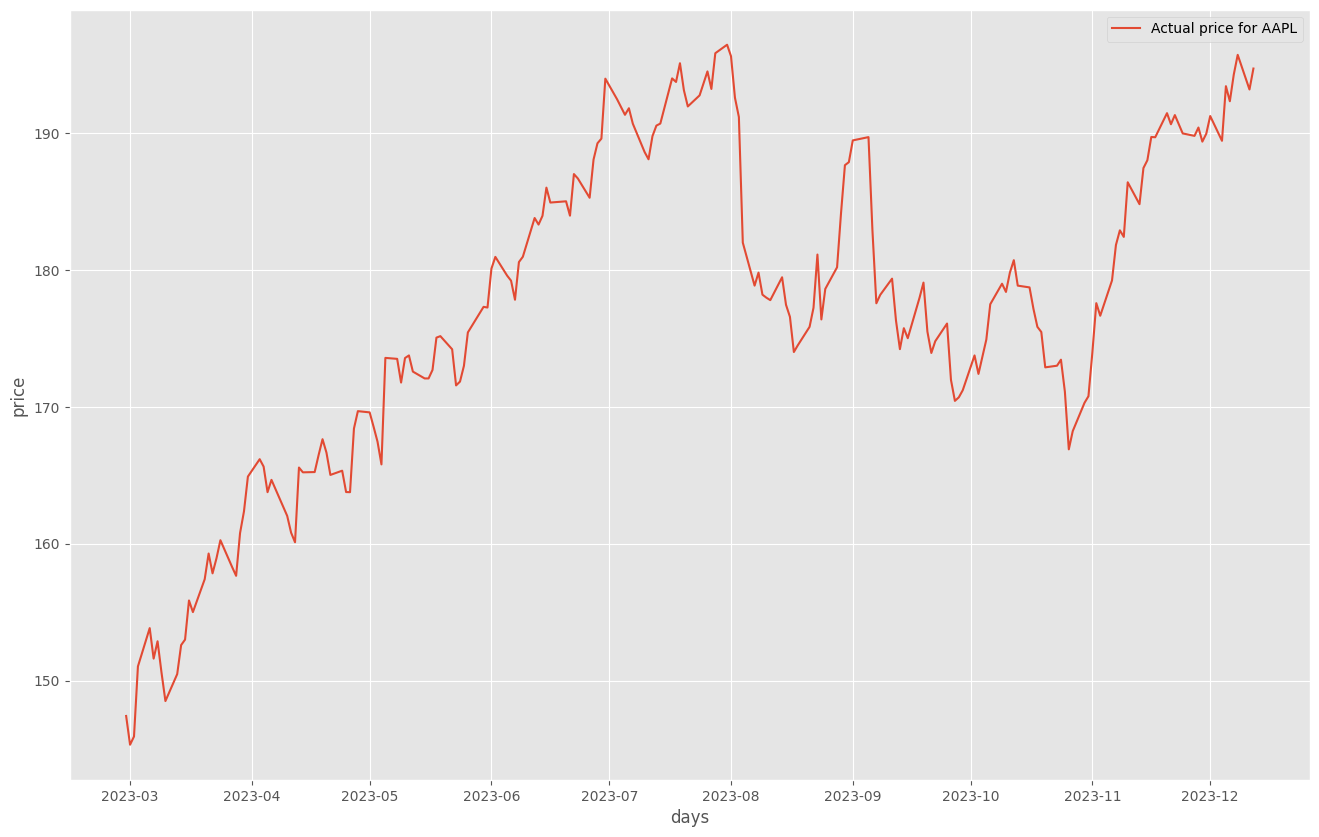

In [21]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [22]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))
display(init_df)

,open,high,low,close,adjclose,volume,ticker,Date,scaled_close
2019-12-16,69.250000,70.197502,69.245003,69.964996,68.162148,128186000,AAPL,2019-12-16,0.098837
2019-12-17,69.892502,70.442497,69.699997,70.102501,68.296082,114158400,AAPL,2019-12-17,0.099817
2019-12-18,69.949997,70.474998,69.779999,69.934998,68.132904,116028400,AAPL,2019-12-18,0.098623
2019-12-19,69.875000,70.294998,69.737503,70.004997,68.201118,98369200,AAPL,2019-12-19,0.099122
2019-12-20,70.557503,70.662498,69.639999,69.860001,68.059837,275978000,AAPL,2019-12-20,0.098089
...,...,...,...,...,...,...,...,...,...
2023-12-06,194.449997,194.759995,192.110001,192.320007,192.320007,41089700,AAPL,2023-12-06,0.970575
2023-12-07,193.630005,195.000000,193.589996,194.270004,194.270004,47477700,AAPL,2023-12-07,0.984468
2023-12-08,194.199997,195.990005,193.669998,195.710007,195.710007,53377300,AAPL,2023-12-08,0.994728
2023-12-11,193.110001,193.490005,191.419998,193.179993,193.179993,60943700,AAPL,2023-12-11,0.976702


In [23]:
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [24]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['Date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [10]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 128
  EPOCHS = 50

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [11]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/50
6/6 [==============================] - 5s 34ms/step - loss: 0.1375
Epoch 2/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0323
Epoch 3/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0139
Epoch 4/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0153
Epoch 5/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0066
Epoch 6/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0051
Epoch 7/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0048
Epoch 8/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0049
Epoch 9/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0045
Epoch 10/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0040
Epoch 11/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0040
Epoch 12/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0038
Epoch 13/50
6/6 [==============================] - 0s 36ms/st

In [12]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

date_now = [predictions[0], f'{date_now}', 0, 0]
date_tomorrow = [predictions[1], f'{date_tomorrow}', 0, 0]
date_after_tomorrow = [predictions[2], f'{date_after_tomorrow}', 0, 0]

24/24 [==============================] - 0s 7ms/step


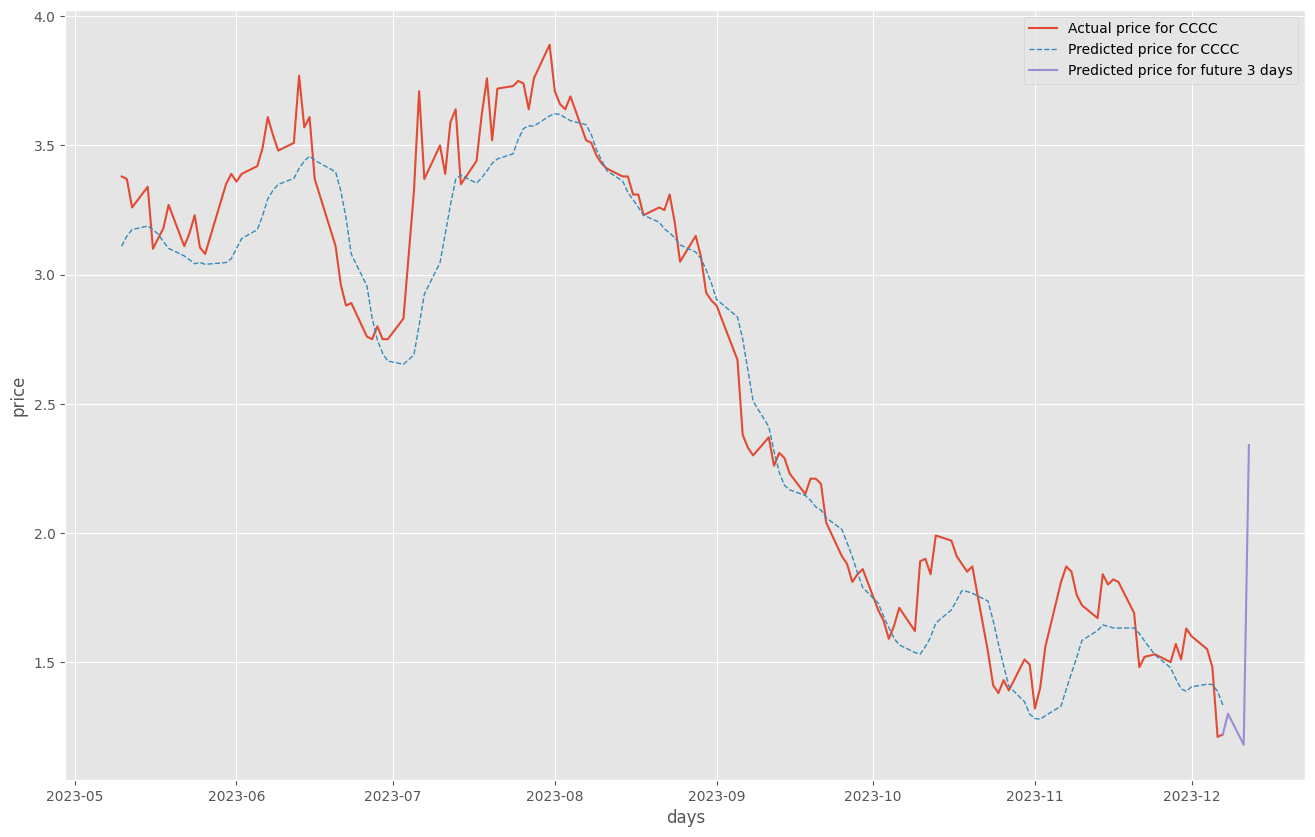

In [14]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

In [15]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = ['$' + str(d) for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

CCCC prediction for upcoming 3 days ($1.49, $1.41, $1.26)
